In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install keras

/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory


In [2]:
def get_prediction(yhat):

    return ["sunflower", "tulip", ][yhat.index(1)]

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os


2024-01-09 22:37:41.352848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 22:37:41.352878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 22:37:41.361329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 22:37:41.435759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 22:37:42.302856: W tensorflow/compiler/tf2

In [4]:
os.chdir('/media/lyonbach/work/Projects/rim-identifier')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" Uncomment if you want to use CPU only

In [5]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

2024-01-09 22:37:43.324375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:37:43.502977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:37:43.503192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Here we could clean the dataset or do some other adjustments if necessary.

In [6]:
# Load data
data = tf.keras.utils.image_dataset_from_directory("dataset").map(lambda x, y: (x/255.0 , y))
# Hot encode labels for four classes
data = data.map(lambda x, y: (x, tf.one_hot(y, 2)))
iterator = data.as_numpy_iterator()

Found 1768 files belonging to 2 classes.


2024-01-09 22:37:43.608953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:37:43.609300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:37:43.609572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
batch = iterator.next()


[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]


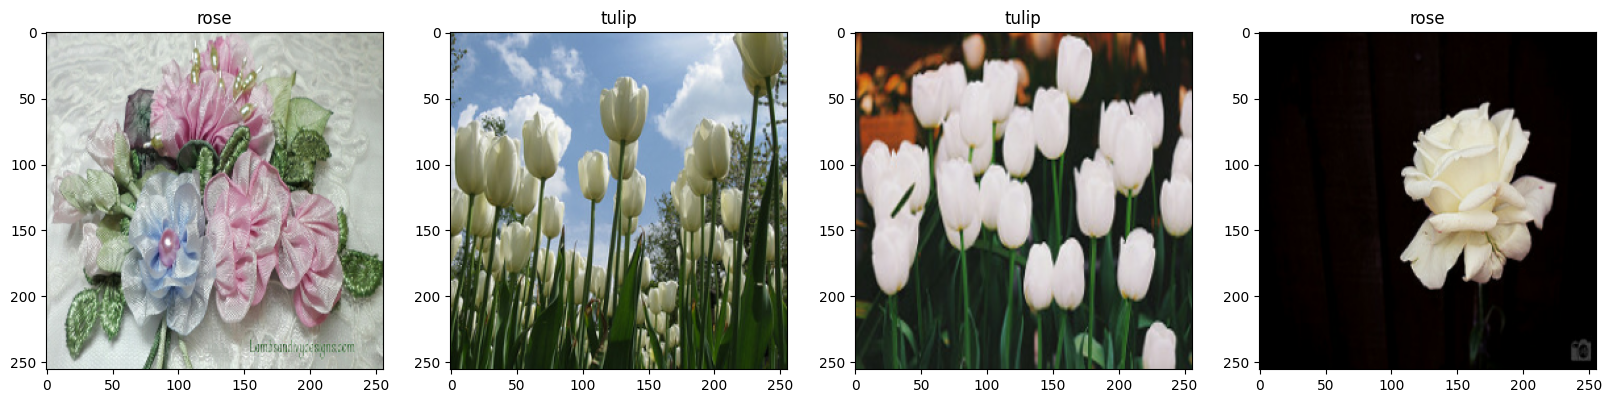

In [8]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    axs[idx].imshow(img)
    axs[idx].set_title(["rose", "tulip", ][list(batch[1][idx]).index(1)])
    print(batch[1][idx])


2. Split the data

In [15]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1) + 1
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size + val_size).take(test_size)

3. Build The Deep Learning Model

In [16]:
assert train_size + val_size + test_size == len(data)
assert len(train) > 0
assert len(val) > 0
assert len(test) > 0

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [18]:
model = Sequential([

    Conv2D(16, 3, 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(8, 3, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu',),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

4. Train The Model

In [20]:
log_dir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


/media/lyonbach/work/Projects/rim-identifier/venv/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-09 22:39:38.237634: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-09 22:39:38.458742: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 22:39:39.617602: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fea545e19d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 22:39:39.617637: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-01-09 22:39:39.634395: I tensorflow/compiler/mlir/tens

44/44 [==============================] - 7s 53ms/step - loss: 0.6893 - accuracy: 0.5859 - val_loss: 0.6718 - val_accuracy: 0.5990
Epoch 2/40
44/44 [==============================] - 3s 56ms/step - loss: 0.6356 - accuracy: 0.6250 - val_loss: 0.5758 - val_accuracy: 0.6979


2024-01-09 22:39:46.190780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 3/40
43/44 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.6802

2024-01-09 22:39:48.771380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 54ms/step - loss: 0.5883 - accuracy: 0.6811 - val_loss: 0.6381 - val_accuracy: 0.6406
Epoch 4/40
44/44 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.6967

2024-01-09 22:39:51.448928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 59ms/step - loss: 0.5693 - accuracy: 0.6967 - val_loss: 0.5040 - val_accuracy: 0.7448
Epoch 5/40
44/44 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7195

2024-01-09 22:39:54.037449: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.5467 - accuracy: 0.7195 - val_loss: 0.5229 - val_accuracy: 0.7240
Epoch 6/40
44/44 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7507

2024-01-09 22:39:56.613763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 55ms/step - loss: 0.5068 - accuracy: 0.7507 - val_loss: 0.5164 - val_accuracy: 0.7448
Epoch 7/40
43/44 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.7667

2024-01-09 22:39:59.230186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 59ms/step - loss: 0.4739 - accuracy: 0.7670 - val_loss: 0.5445 - val_accuracy: 0.7396
Epoch 8/40
44/44 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.7763

2024-01-09 22:40:01.898476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.4464 - accuracy: 0.7763 - val_loss: 0.5054 - val_accuracy: 0.7917
Epoch 9/40
43/44 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8009

2024-01-09 22:40:04.427066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.4031 - accuracy: 0.7997 - val_loss: 0.5011 - val_accuracy: 0.7500
Epoch 10/40
44/44 [==============================] - 2s 54ms/step - loss: 0.3598 - accuracy: 0.8402 - val_loss: 0.5033 - val_accuracy: 0.7240


2024-01-09 22:40:06.931548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 11/40
43/44 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8634

2024-01-09 22:40:09.544705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.3126 - accuracy: 0.8651 - val_loss: 0.4745 - val_accuracy: 0.7917
Epoch 12/40
44/44 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8928

2024-01-09 22:40:12.120181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.2609 - accuracy: 0.8928 - val_loss: 0.4761 - val_accuracy: 0.7448
Epoch 13/40
44/44 [==============================] - 3s 55ms/step - loss: 0.2114 - accuracy: 0.9155 - val_loss: 0.4330 - val_accuracy: 0.8281


2024-01-09 22:40:14.840033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 14/40
44/44 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9197

2024-01-09 22:40:17.312524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 55ms/step - loss: 0.1879 - accuracy: 0.9197 - val_loss: 0.3497 - val_accuracy: 0.8385
Epoch 15/40
44/44 [==============================] - 2s 54ms/step - loss: 0.1445 - accuracy: 0.9489 - val_loss: 0.4838 - val_accuracy: 0.8542


2024-01-09 22:40:19.915849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 16/40
44/44 [==============================] - 3s 54ms/step - loss: 0.1785 - accuracy: 0.9268 - val_loss: 0.3942 - val_accuracy: 0.8542
Epoch 17/40
44/44 [==============================] - 2s 53ms/step - loss: 0.1041 - accuracy: 0.9688 - val_loss: 0.6664 - val_accuracy: 0.8490


2024-01-09 22:40:25.094855: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 18/40
44/44 [==============================] - 2s 53ms/step - loss: 0.0643 - accuracy: 0.9787 - val_loss: 0.5352 - val_accuracy: 0.8750


2024-01-09 22:40:27.628940: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 19/40
44/44 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9879

2024-01-09 22:40:30.193970: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.0478 - accuracy: 0.9879 - val_loss: 0.4433 - val_accuracy: 0.9010
Epoch 20/40
44/44 [==============================] - 2s 54ms/step - loss: 0.0421 - accuracy: 0.9858 - val_loss: 0.5633 - val_accuracy: 0.9167


2024-01-09 22:40:32.769083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 21/40
43/44 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9906

2024-01-09 22:40:35.367293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.0387 - accuracy: 0.9893 - val_loss: 0.5144 - val_accuracy: 0.9062
Epoch 22/40
44/44 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9908

2024-01-09 22:40:37.870076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 55ms/step - loss: 0.0398 - accuracy: 0.9908 - val_loss: 0.4783 - val_accuracy: 0.9062
Epoch 23/40
43/44 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9906

2024-01-09 22:40:40.494263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.0336 - accuracy: 0.9908 - val_loss: 0.7094 - val_accuracy: 0.8906
Epoch 24/40
44/44 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9929

2024-01-09 22:40:43.136327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.5382 - val_accuracy: 0.9167
Epoch 25/40
44/44 [==============================] - 2s 53ms/step - loss: 0.0387 - accuracy: 0.9858 - val_loss: 0.4935 - val_accuracy: 0.8750


2024-01-09 22:40:45.671226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 26/40
43/44 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891

2024-01-09 22:40:48.168915: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 55ms/step - loss: 0.0355 - accuracy: 0.9886 - val_loss: 0.4943 - val_accuracy: 0.9167
Epoch 27/40
44/44 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9915

2024-01-09 22:40:50.787085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 57ms/step - loss: 0.0358 - accuracy: 0.9915 - val_loss: 0.6446 - val_accuracy: 0.8906
Epoch 28/40
43/44 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9862

2024-01-09 22:40:53.382198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 57ms/step - loss: 0.0485 - accuracy: 0.9858 - val_loss: 0.4875 - val_accuracy: 0.9167
Epoch 29/40
44/44 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9936

2024-01-09 22:40:56.021787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 56ms/step - loss: 0.0359 - accuracy: 0.9936 - val_loss: 0.4943 - val_accuracy: 0.9010
Epoch 30/40
43/44 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9971

2024-01-09 22:40:58.680047: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 57ms/step - loss: 0.0185 - accuracy: 0.9972 - val_loss: 0.4206 - val_accuracy: 0.9271
Epoch 31/40
43/44 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9956

2024-01-09 22:41:01.391109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 57ms/step - loss: 0.0191 - accuracy: 0.9957 - val_loss: 0.5041 - val_accuracy: 0.9219
Epoch 32/40
44/44 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9943

2024-01-09 22:41:03.948305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 54ms/step - loss: 0.0249 - accuracy: 0.9943 - val_loss: 0.4437 - val_accuracy: 0.9219
Epoch 33/40
44/44 [==============================] - 2s 54ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.8333 - val_accuracy: 0.8854


2024-01-09 22:41:06.452655: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 34/40
44/44 [==============================] - 3s 55ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.6643 - val_accuracy: 0.9219


2024-01-09 22:41:09.038219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 35/40
44/44 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9972

2024-01-09 22:41:11.610324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.3995 - val_accuracy: 0.9115
Epoch 36/40
44/44 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9979

2024-01-09 22:41:14.133737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 2s 54ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.6169 - val_accuracy: 0.9062
Epoch 37/40
44/44 [==============================] - 2s 54ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.5174 - val_accuracy: 0.9167


2024-01-09 22:41:16.645721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 38/40
44/44 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9972

2024-01-09 22:41:19.210505: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 [==============================] - 3s 55ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.6123 - val_accuracy: 0.9271
Epoch 39/40
44/44 [==============================] - 2s 54ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.4856 - val_accuracy: 0.9167


2024-01-09 22:41:21.893127: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 40/40
44/44 [==============================] - 3s 56ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 0.2290 - val_accuracy: 0.9583


5. Plot the Performance

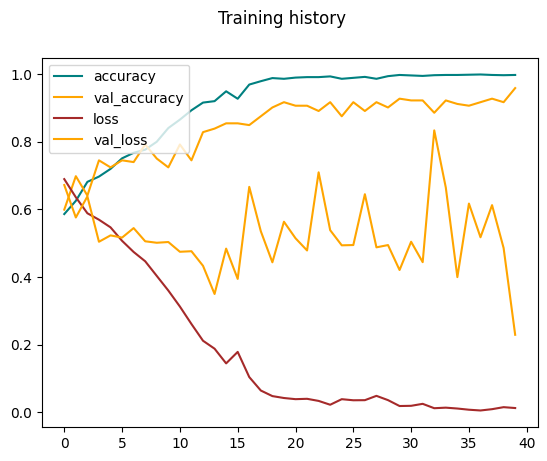

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(hist.history['loss'], color='brown', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='upper left')
fig.suptitle('Training history')
plt.show()

6. Evaluation

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()


In [24]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 27ms/step


In [25]:
print("Precision: ", pre.result().numpy())
print("Recall: ", rec.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  0.9947917
Recall:  0.9947917
Accuracy:  0.9947917


7. Test

In [36]:
import cv2
image_path = "archive/flowers/outer/960x0.webp"
# image_path = "dataset/daisy/134409839_71069a95d1_m.jpg"
#image_path = "dataset/rose/295257304_de893fc94d.jpg"
# image_path = "dataset/rose/27619697563_228f5c4677_n.jpg"
# image_path = "archive/flowers/outer/360_F_112824975_5fILgyzThND6nmq8sycuyF8j8pKnpAgl.jpg"
# image_path = "archive/flowers/outer/F1271-1.webp"
# image_path = "dataset/sunflower/29972905_4cc537ff4b_n.jpg"
# image_path = "dataset/sunflower/151898652_b5f1c70b98_n.jpg"
# image_path = "archive/flowers/outer/360_F_575078345_LryQMyfSCcKL4e8uUYw1LJ2Re6ffn2cF.jpg"
# image_path = "archive/flowers/outer/transparent-sunflower-651d0e8c7c3ce8.0350226316964030845089.jpg"
image = cv2.imread(image_path)

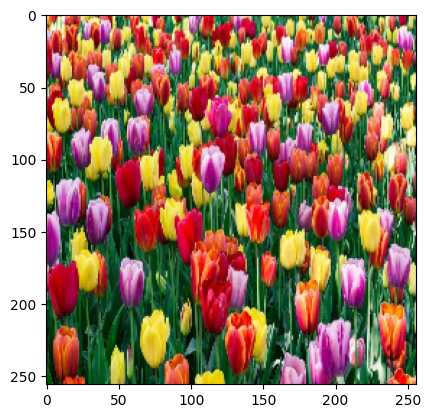

In [37]:
resized = cv2.resize(image, (256, 256))
# change color space
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

8. Prediction

In [38]:
yhat = model.predict(np.expand_dims(resized/255.0, 0))
print(yhat)
print(np.argmax(yhat[0]))

1/1 [==============================] - 0s 14ms/step
[[2.6068114e-34 1.0000000e+00]]
1
